In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import urllib.request
import os

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing

### 1. 数据预处理

#### 1.1 读取之前下载的数据集

In [3]:
file_path = 'data/titanic3.xls'
all_df = pd.read_excel(file_path)

#### 1.2 把需要的字段选取到 DataFrame 中

In [4]:
cols = ['survived', 'name', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
all_df = all_df[cols]

#### 1.3 将数据以随机方式分为训练数据与测试数据

In [5]:
mask = np.random.rand(len(all_df)) < 0.8
train_df = all_df[mask]
test_df = all_df[~mask]

print('total size:', len(all_df))
print('train size:', len(train_df))
print('test size:', len(test_df))

total size: 1309
train size: 1028
test size: 281


#### 1.4 创建函数进行数据的预处理

In [6]:
def preprocess_data(raw_df):
    df = raw_df.drop(['name'], axis=1)
    age_mean = df['age'].mean()
    df['age'] = df['age'].fillna(age_mean)
    fare_mean = df['fare'].mean()
    df['fare'] = df['fare'].fillna(fare_mean)
    df['sex'] = df['sex'].map({'female': 0, 'male': 1}).astype(int)
    x_one_hot_df = pd.get_dummies(data=df, columns=['embarked'])
    
    ndarray = x_one_hot_df.values
    label = ndarray[:, 0]
    features = ndarray[:, 1:]
    
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaled_features = minmax_scale.fit_transform(features)
    
    return scaled_features, label

In [7]:
train_features, train_label = preprocess_data(train_df)
test_features, test_label = preprocess_data(test_df)

### 2. 建立模型

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=40, input_dim=9, kernel_initializer='normal', activation='relu'), # 输入层-隐藏层1(40个神经元)
    tf.keras.layers.Dense(units=30, kernel_initializer='normal', activation='relu'),  # 隐藏层2(30个神经元)
    tf.keras.layers.Dense(units=1, kernel_initializer='normal', activation='sigmoid')
])

In [9]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                400       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 1,661
Trainable params: 1,661
Non-trainable params: 0
_________________________________________________________________
None


### 3. 开始训练

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
train_history = model.fit(x=train_features, y=train_label, validation_split=0.1,
                         epochs=30, batch_size=50, verbose=2)

Train on 925 samples, validate on 103 samples
Epoch 1/30
 - 1s - loss: 8.1463 - acc: 0.4216 - val_loss: 8.4040 - val_acc: 0.3010
Epoch 2/30
 - 0s - loss: 5.3868 - acc: 0.4616 - val_loss: 2.5593 - val_acc: 0.6796
Epoch 3/30
 - 0s - loss: 3.1485 - acc: 0.6270 - val_loss: 2.4892 - val_acc: 0.7087
Epoch 4/30
 - 0s - loss: 2.4007 - acc: 0.6389 - val_loss: 2.0968 - val_acc: 0.6990
Epoch 5/30
 - 0s - loss: 1.9173 - acc: 0.6865 - val_loss: 1.9336 - val_acc: 0.7184
Epoch 6/30
 - 0s - loss: 1.6833 - acc: 0.6973 - val_loss: 1.8348 - val_acc: 0.7087
Epoch 7/30
 - 0s - loss: 1.5773 - acc: 0.7027 - val_loss: 1.7284 - val_acc: 0.6893
Epoch 8/30
 - 0s - loss: 1.4963 - acc: 0.7016 - val_loss: 1.6070 - val_acc: 0.6990
Epoch 9/30
 - 0s - loss: 1.4033 - acc: 0.7124 - val_loss: 1.4921 - val_acc: 0.6990
Epoch 10/30
 - 0s - loss: 1.3156 - acc: 0.7157 - val_loss: 1.3886 - val_acc: 0.7087
Epoch 11/30
 - 0s - loss: 1.2297 - acc: 0.7157 - val_loss: 1.3000 - val_acc: 0.7379
Epoch 12/30
 - 0s - loss: 1.1510 - acc:

### 4. 以图形显示训练过程

In [12]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.xlabel('Epoch')
    plt.ylabel(train)
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

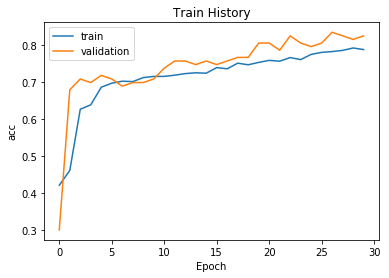

In [13]:
show_train_history(train_history, 'acc', 'val_acc')

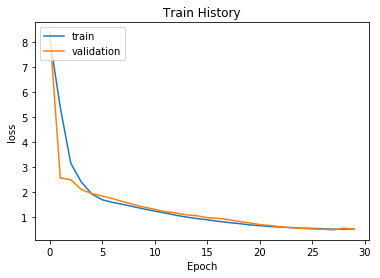

In [14]:
show_train_history(train_history, 'loss', 'val_loss')

### 5. 评估模型的准确率

In [15]:
scores = model.evaluate(x=test_features, y=test_label)
print()
print('accuracy:', scores[1])

281/281 [==============================] - 0s 54us/step

accuracy: 0.7864768659941243


### 6. 加入 Jack 与 Rose 的数据

#### 6.1 建立 Jack 与 Rose 的数据

In [16]:
jack_data = pd.Series([0, 'Jack', 3, 'male', 23, 1, 0, 5.0000, 'S'])
rose_data = pd.Series([1, 'Rose', 1, 'female', 20, 1, 0, 100.0000, 'S'])

#### 6.2 创建 Jack 与 Rose 的 DataFrame

In [17]:
jr_df = pd.DataFrame([list(jack_data), list(rose_data)], 
                     columns=['survived', 'name', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked'])

#### 6.3 将 jf_df 加入到 all_df 的最后

In [18]:
all_df = pd.concat([all_df, jr_df])
all_df[-2:]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked
0,0,Jack,3,male,23.0,1,0,5.0,S
1,1,Rose,1,female,20.0,1,0,100.0,S


### 7. 进行预测

#### 7.1 执行数据预处理

In [19]:
all_features, all_label = preprocess_data(all_df)

#### 7.2 执行预测

In [20]:
all_probability = model.predict(all_features)

#### 7.3 查看预测结果的前10项

In [21]:
all_probability[:10]

array([[0.89957434],
       [0.830749  ],
       [0.9837351 ],
       [0.08564571],
       [0.9842621 ],
       [0.33270726],
       [0.8360097 ],
       [0.6762183 ],
       [0.94551647],
       [0.0848799 ]], dtype=float32)

#### 7.4 将 all_df 与 all_probability 整合

In [22]:
predicted_all_df = all_df
predicted_all_df.insert(len(all_df.columns), 'probability', all_probability)

#### 7.5 查看 Jack 与 Rose 预测的生存概率

In [23]:
predicted_all_df[-2:]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
0,0,Jack,3,male,23.0,1,0,5.0,S,0.36610
1,1,Rose,1,female,20.0,1,0,100.0,S,0.99245


### 8. 查看生存几率高, 却没有存活样例

In [24]:
predicted_all_df[(predicted_all_df['survived']==0) & (predicted_all_df['probability'] > 0.9)]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
2,0,"Allison, Miss. Helen Loraine",1,female,2.0,1,2,151.5500,S,0.983735
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,female,25.0,1,2,151.5500,S,0.984262
25,0,"Birnbaum, Mr. Jakob",1,male,25.0,0,0,26.0000,C,0.919381
105,0,"Evans, Miss. Edith Corse",1,female,36.0,0,0,31.6792,C,0.994296
169,0,"Isham, Miss. Ann Elizabeth",1,female,50.0,0,0,28.7125,C,0.985536
228,0,"Penasco y Castellana, Mr. Victor de Satode",1,male,18.0,1,0,108.9000,C,0.959834
365,0,"Carter, Mrs. Ernest Courtenay (Lilian Hughes)",2,female,44.0,1,0,26.0000,S,0.963926
369,0,"Chapman, Mrs. John Henry (Sara Elizabeth Lawry)",2,female,29.0,1,0,26.0000,S,0.991723
381,0,"Corbett, Mrs. Walter H (Irene Colvin)",2,female,30.0,0,0,13.0000,S,0.973334
382,0,"Corey, Mrs. Percy C (Mary Phyllis Elizabeth Mi...",2,female,NaN,0,0,21.0000,S,0.970802


In [25]:
predicted_all_df[:5]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
0,1,"Allen, Miss. Elisabeth Walton",1,female,29.0000,0,0,211.3375,S,0.899574
1,1,"Allison, Master. Hudson Trevor",1,male,0.9167,1,2,151.5500,S,0.830749
2,0,"Allison, Miss. Helen Loraine",1,female,2.0000,1,2,151.5500,S,0.983735
3,0,"Allison, Mr. Hudson Joshua Creighton",1,male,30.0000,1,2,151.5500,S,0.085646
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,female,25.0000,1,2,151.5500,S,0.984262
